In [1]:
%matplotlib inline

from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path

@dataclass
class Results:
    name: str
    M: np.ndarray
    N: np.ndarray
    K: np.ndarray
    mem_usage: np.ndarray
    mflops: np.ndarray

In [6]:
# read data
# lib_used="libmatmult_base"
lib_used="libmatmult_O3"
# lib_used="libmatmult_O3_fast-math_unroll-loopsO3_fast-math_unroll-loops"
RESULTS_FILE = Path(f"results/{lib_used}_results.dat")

if not RESULTS_FILE.exists():
    raise FileNotFoundError("results files does not exist")

# ---------
PERMS = [
    "mnk",
    # "nmk",
    # "mkn",
    # "nkm",
    # "kmn",
    # "knm"
    ]
RUNS_PER_PERM = 8

cache_levels = [ # in kB
    32, # L1 
    256,# L2 
    30_000 # L3
    ]

data:np.ndarray = np.loadtxt(RESULTS_FILE)
split = np.split(data,len(PERMS),0)


assert (data.shape == (RUNS_PER_PERM*len(PERMS), 6))
print(f"data shape: {data.shape}") # Should be (perms x len(M)) x 6

data shape: (8, 6)


In [7]:
results_dict:Dict[str,Results] = dict()

for data, perm in zip(split, PERMS):
    # print(perm, data.shape)

    result = Results(
        name=perm, 
        M = data[:,0].reshape((RUNS_PER_PERM,1)),
        N = data[:,1].reshape((RUNS_PER_PERM,1)),
        K = data[:,2].reshape((RUNS_PER_PERM,1)),
        mem_usage = data[:,3].reshape((RUNS_PER_PERM,1)),
        mflops = data[:,4].reshape((RUNS_PER_PERM,1))
    )
    results_dict[perm] = result
    

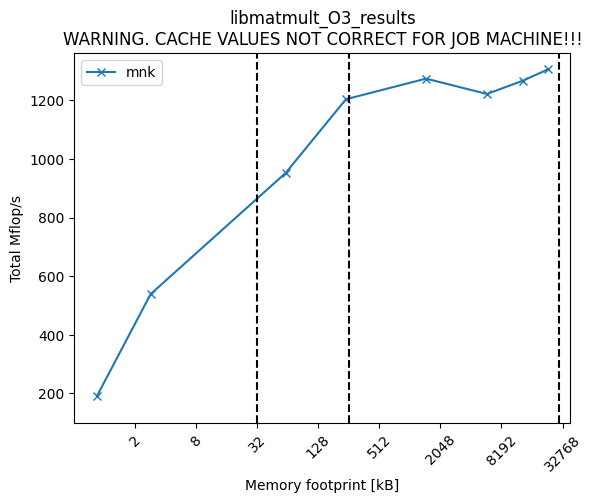

In [8]:
plt.figure()

for perm, res in results_dict.items():
    plt.plot(res.mem_usage, res.mflops,"-x",label=res.name)

plt.legend()

# log scale for X axis
plt.xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.locator_params(axis='x', numticks=13)

for cache_level in cache_levels:
    plt.axvline(cache_level, color='k', linestyle='--')

# make the ticks on an angle
plt.xticks(rotation=45)

plt.xlabel('Memory footprint [kB]')
plt.ylabel('Total Mflop/s')

# set y-axis lower limit to 0
plt.ylim(bottom=100)

plt.title(f"{RESULTS_FILE.stem}\nWARNING. CACHE VALUES NOT CORRECT FOR JOB MACHINE!!!")

plt.savefig(f"results/{RESULTS_FILE.stem}.png")
plt.show()
